## 1. Importing Libraries

In [88]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.tokenize import WhitespaceTokenizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer   
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

## 2. Loading Dataset

In [2]:
messages=[line.rstrip() for line in open('SMSSpamCollection')]

In [3]:
print(len(messages))

5574


In [10]:
df_sms = pd.read_csv('SMSSpamCollection', sep='\t', names=['label','message'])

In [11]:
df_sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
df_sms.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


## 3. Exploratory Data Analysis

In [13]:
df_sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [14]:
df_sms['length']=df_sms['message'].apply(lambda x: len(x))

In [15]:
df_sms.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


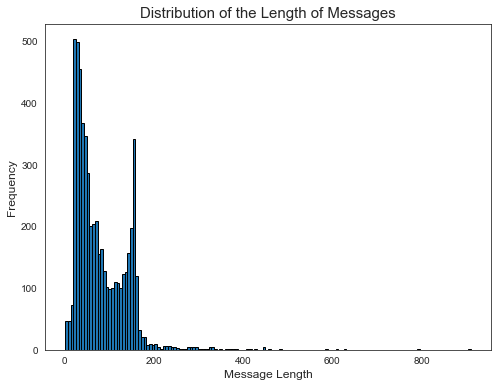

In [22]:
plt.figure(figsize=(8,6))
plt.hist(x='length', bins=150, data=df_sms,edgecolor='black')
plt.title('Distribution of the Length of Messages', fontsize=15)
plt.xlabel('Message Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [23]:
df_sms['length'].max()

910

In [24]:
df_sms['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [25]:
df_sms[df_sms['length']==910]['message']

1085    For me the love should start with attraction.i...
Name: message, dtype: object

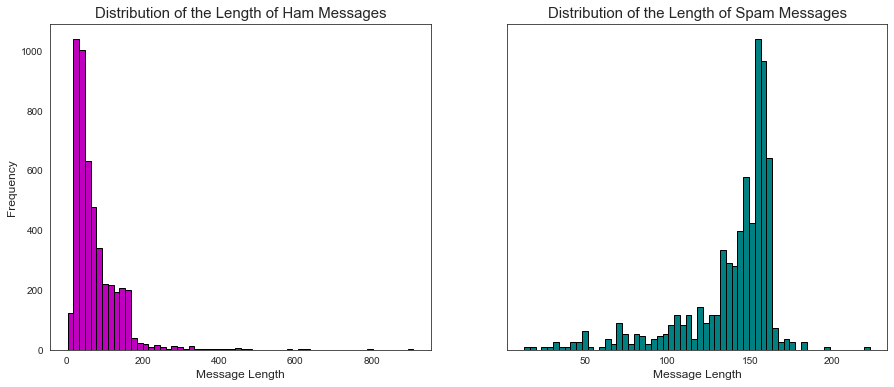

In [28]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.hist(x='length', bins=60, data=df_sms[df_sms['label']=='ham'],edgecolor='black', color='m')
plt.title('Distribution of the Length of Ham Messages', fontsize=15)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Message Length', fontsize=12)

plt.subplot(1,2,2)
plt.hist(x='length', bins=60, data=df_sms[df_sms['label']=='spam'],edgecolor='black', color='teal')
plt.title('Distribution of the Length of Spam Messages', fontsize=15)
plt.ylabel('')
plt.yticks([])
plt.xlabel('Message Length', fontsize=12)

plt.show()

## 4. Ham/Spam Messages Prediction

### 4.1. Text Preprocessing Function

We define a preprocessing function that performs the following operations:

- Converting text to lower case

- Removing numbers from the text corpus

- Removing punctuation from the text corpus

- Removing special characters such as ‘<’, ‘…’ from the text corpus

- Removing english stopwords

- Stemming words to root words

- Removing extra whitespaces from the text corpus

In [31]:
ps=PorterStemmer()
wst= WhitespaceTokenizer() 

##### 1. Converting text to lower case
def lower_func (x):
    return x.lower()


##### 2. Removing Numbers from the text corpus
def remove_number_func (x): 
    new=""
    for a in x:
        if a.isdigit()==False:
            new=new+a
    return new


##### 3. Removing punctuation 
def remove_punc_func(x):
    new=''
    for a in x:
        if a not in string.punctuation:
            new=new+a
    return new

##### 4. Removing special characters
def remove_spec_char_func(x):
    new=''
    for a in x:
        if (a.isalnum()==True) or (a==' '):
            new=new+a
    return(new)

##### 5. Removing english stopwords
def remove_stopwords(x):
    new=[]
    for a in x.split():
        if a not in stopwords.words('english'):
            new.append(a)
    return " ".join(new)

##### 6. Stemming words to root words
def stem_func(x):
    wordlist = word_tokenize(x)
    psstem = [ps.stem(a) for a in wordlist]
    return ' '.join(psstem)

##### 7. Removing extra whitespaces 
def remove_whitespace_func(x):
    return(wst.tokenize(x))

def compose(f, g):
    return lambda x: f(g(x))

final=compose(compose(compose(compose(compose(compose(remove_whitespace_func,stem_func),remove_stopwords),remove_spec_char_func),remove_punc_func),remove_number_func),lower_func)

### 4.2. Splitting the Dataset 

In [32]:
X=df_sms['message']
y=df_sms['label']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 4.3. Creating Data Pipeline

#### 4.3.1. MultinomialNB Classifier without Text Preprocessing 

In [48]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', MultinomialNB()), 
])

In [49]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [50]:
prediction1=pipeline.predict(X_test)

In [51]:
print(classification_report(y_test,prediction1))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.98       957
        spam       1.00      0.70      0.83       158

    accuracy                           0.96      1115
   macro avg       0.98      0.85      0.90      1115
weighted avg       0.96      0.96      0.95      1115



#### 4.3.2. MultinomialNB Classifier with Text Preprocessing

In [52]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=final)),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', MultinomialNB()), 
])

In [53]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x000002045AFEAD38>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose

In [54]:
prediction2=pipeline.predict(X_test)

In [56]:
print(classification_report(y_test,prediction2))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       957
        spam       0.99      0.75      0.86       158

    accuracy                           0.96      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.96      0.96      1115



#### 4.3.3. MultinomialNB Classifier with Only Removing Stop Words

In [57]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer='word', stop_words='english')),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', MultinomialNB()), 
])

In [58]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [59]:
prediction3=pipeline.predict(X_test)

In [60]:
print(classification_report(y_test,prediction3))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       957
        spam       1.00      0.79      0.88       158

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115



#### 4.3.4. Passive Aggressive Classifier without Text Preprocessing

In [63]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', PassiveAggressiveClassifier()), 
])

In [64]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
                                          

In [65]:
prediction4=pipeline.predict(X_test)

In [66]:
print(classification_report(y_test,prediction4))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       957
        spam       0.99      0.94      0.97       158

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



#### 4.3.5. Passive Aggressive Classifier with Text Preprocessing

In [67]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=final)),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', PassiveAggressiveClassifier()), 
])

In [68]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x000002045AFEAD38>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
                                             early_stopping=False,
       

In [69]:
prediction5=pipeline.predict(X_test)

In [70]:
print(classification_report(y_test,prediction5))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       957
        spam       0.97      0.95      0.96       158

    accuracy                           0.99      1115
   macro avg       0.98      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



#### 4.3.6. Passive Aggressive Classifier with Only Removing Stop Words

In [71]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer='word', stop_words='english')),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', PassiveAggressiveClassifier()), 
])

In [72]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 PassiveAggressiveClassifier(C=1.0, average=False,
                                             class_weight=None,
                                          

In [73]:
prediction6=pipeline.predict(X_test)

In [74]:
print(classification_report(y_test,prediction6))

              precision    recall  f1-score   support

         ham       0.99      1.00      1.00       957
        spam       1.00      0.94      0.97       158

    accuracy                           0.99      1115
   macro avg       1.00      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



#### 4.3.7. Random Forest Classifier without Text Preprocessing

In [75]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', RandomForestClassifier()), 
])

In [76]:
pipeline.fit(X_train, y_train)

C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

In [77]:
prediction7=pipeline.predict(X_test)

In [78]:
print(classification_report(y_test,prediction7))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       957
        spam       1.00      0.78      0.88       158

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



#### 4.3.8. Random Forest  Classifier with Text Preprocessing

In [79]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=final)),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', RandomForestClassifier()), 
])

In [80]:
pipeline.fit(X_train, y_train)

C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function compose.<locals>.<lambda> at 0x000002045AFEAD38>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                              

In [81]:
prediction8=pipeline.predict(X_test)

In [82]:
print(classification_report(y_test,prediction8))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       957
        spam       0.99      0.82      0.90       158

    accuracy                           0.97      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115



#### 4.3.9. Random Forest  Classifier with Only Removing Stop Words

In [83]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer='word', stop_words='english')),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', RandomForestClassifier()), 
])

In [84]:
pipeline.fit(X_train, y_train)

C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

In [85]:
prediction9=pipeline.predict(X_test)

In [86]:
print(classification_report(y_test,prediction9))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       957
        spam       0.99      0.80      0.88       158

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115



In [89]:
print('MultinomialNB Classifier without text pre-processing', accuracy_score(y_test,prediction1))
print('MultinomialNB Classifier with text pre-processing: ', accuracy_score(y_test,prediction2))
print('MultinomialNB Classifier with only removing stop words', accuracy_score(y_test,prediction3))
print('\n')
print('Passive Aggressive Classifier without text pre-processing: ', accuracy_score(y_test,prediction4))
print('Passive Aggressive Classifier with text pre-processing: ', accuracy_score(y_test,prediction5))
print('Passive Aggressive Classifier with only removing stop words: ', accuracy_score(y_test,prediction6))
print('\n')
print('Random Forest Classifier without text pre-processing: ', accuracy_score(y_test,prediction7))
print('Random Forest Classifier with text pre-processing: ', accuracy_score(y_test,prediction8))
print('Random Forest Classifier with only removing stop words: ', accuracy_score(y_test,prediction9))

MultinomialNB Classifier without text pre-processing 0.957847533632287
MultinomialNB Classifier with text pre-processing:  0.9641255605381166
MultinomialNB Classifier with only removing stop words 0.9704035874439462


Passive Aggressive Classifier without text pre-processing:  0.9910313901345291
Passive Aggressive Classifier with text pre-processing:  0.9883408071748879
Passive Aggressive Classifier with only removing stop words:  0.9919282511210762


Random Forest Classifier without text pre-processing:  0.968609865470852
Random Forest Classifier with text pre-processing:  0.9730941704035875
Random Forest Classifier with only removing stop words:  0.9704035874439462


We can see that the Passive Agreesive Classifier is more effective in predicting whether sms is ham or spam as compared with MultinomialNB and Random Forest Classifiers. The highest accuracy score was obtained for the Passive Agreesive Classifier with  with only removing stop words.

## 5. Conclusion

In this project, the following tasks were preformed:

- We performed exploratory data analysis on the SMS Spam Collection Dataset. 

- We built binary classifiers that classify ham and spam messages. We used three different classifiers including Random Forest Classifier, Naive-Bayes Classifier and passive Agressive Classifier to classify messages into ham/spam categories and applied them with and without text preprocessing and with only removing the stop words.

- Passive Aggressive was the best model for this analysis of the messages. The highest accuracy was 99.19% and it was obtained for the Passive Aggressive model applied on the messages which only their stop words have been removed.